In [1]:



def sample_func(index):
    print('index: %s started.' % index)
    sleep_seconds = random.randint(2, 4)
    time.sleep(sleep_seconds)
    print('index: %s ended.' % index)
    return 0


future_list = []
with futures.ThreadPoolExecutor(max_workers=4) as executor:
    for i in range(2):
        future = executor.submit(sample_func, index=i)
        future_list.append(future)
    _ = futures.as_completed(fs=future_list)
print([f.result() for f in future_list])
print('completed.')

index: 0 started.
index: 1 started.
index: 1 ended.
index: 0 ended.
[0, 0]
completed.


In [36]:
from concurrent import futures
import time
import random
import numpy as np
import miepython
from scipy import integrate
import os
import warnings
warnings.simplefilter('ignore')

In [2]:
def approximate_qbb_polynomial(lambda0,mreal,PSD=np.logspace(0.05*1e-6,500*1e-6,100)):
    """
    lambda0 ; wavelength in nm
    D : particle size in m
    """
    def n(lambda0,coef1=0.010658,coef2=-0.007186):
            return coef1*np.exp(coef2*lambda0)
    
    def qbb(D):

        x = 2 * np.pi * D /(lambda0*1e-9)
        m = mreal-n(lambda0)*1j

        def scattering_for_eachAngle(theta):
            cos = np.cos(np.radians(theta))
            sin = np.sin(np.radians(theta))

            S1,S2 = miepython.mie_S1_S2(m,x,cos,norm="wiscombe")
            i1 = abs(S1) ** 2
            i2 = abs(S2) ** 2
            I  = i1+i2
            return I*sin
        integrated,err = integrate.quad(scattering_for_eachAngle,90,180)

        return integrated/(x**2)
    
    #start multiProcessing
    future_list = []
    with futures.ProcessPoolExecutor(os.cpu_count()) as executor:
        for i in PSD:
            future = executor.submit(qbb, D=i)
            future_list.append(future)
        _ = futures.as_completed(fs=future_list)


    return [f.result() for f in future_list]

In [ ]:
approximate_qbb_polynomial(400,1.12)

In [61]:
result = [qbb(D) for D in np.linspace(0.05*1e-6,500*1e-6,10)]

In [109]:
   
def qbb(D,lambda0=np.linspace(400,800,4),mreal=1.12):
    def n(lambda0,coef1=0.010658,coef2=-0.007186):
        return coef1*np.exp(coef2*lambda0)
    
    result = []

    for lambda0 in lambda0:
        x = 2 * np.pi * D /(lambda0*1e-9)
        m = mreal-n(lambda0)*1j

        def scattering_for_eachAngle(theta):
            cos = np.cos(np.radians(theta))
            sin = np.sin(np.radians(theta))

            S1,S2 = miepython.mie_S1_S2(m,x,cos,norm="wiscombe")
            i1 = abs(S1) ** 2
            i2 = abs(S2) ** 2
            I  = i1+i2
            return I*sin

        integrated,err = integrate.quad(scattering_for_eachAngle,90,180,limit=100)
        result.append(integrated/(x**2))
    return result

def task(lambda0,PSD,mreal):
    """
    1000;40.4s
    """
    #print(f"---------task : lambda {lambda0[0]} started-------------")
    length = PSD.shape[0]
    print(length)
    mreal = [mreal for i in range(length)]
    lambda0 = [lambda0 for i in range(length)]
    with futures.ProcessPoolExecutor(os.cpu_count()) as executor:
        future_list = executor.map(qbb,PSD,lambda0,mreal)
    #print(f"---------task : lambda {lambda0} ended-------------")
    return future_list


In [122]:
PSD = np.r_[np.linspace(0.05*1e-6,0.1*1e-6,200),np.linspace(0.1*1e-6,1*1e-6,300)
      ,np.linspace(1*1e-6,10*1e-6,300),np.linspace(10*1e-6,100*1e-6,150)
      ,np.linspace(100*1e-6,500*1e-6,50)]
mreal = 1.12
result = list(task(np.linspace(400,800,21),PSD,mreal))

1000


In [ ]:
np.r_[np.linspace(0.05*1e-6,1*1e-6,200),np.linspace(1*1e-6,10*1e-6,200)
      ,np.linspace(10*1e-6,100*1e-6,200),np.linspace(100*1e-6,1000*1e-6,200)
      ,np.linspace(1000*1e-6,10000*1e-6,200)]

In [88]:
print(np.linspace(400,800,21))

[400. 420. 440. 460. 480. 500. 520. 540. 560. 580. 600. 620. 640. 660.
 680. 700. 720. 740. 760. 780. 800.]


In [112]:
result = np.array(list(result))
print(np.array(list(result)))
#list[i][j] i:lambda(400,500,600,700...) j: D(PSD) #gyaku

[[0.12638853 0.01024459]
 [0.16897714 0.0145134 ]
 [0.21710635 0.01991068]
 ...
 [0.10625981 0.10631484]
 [0.10625981 0.10627843]
 [0.10625981 0.10630034]]


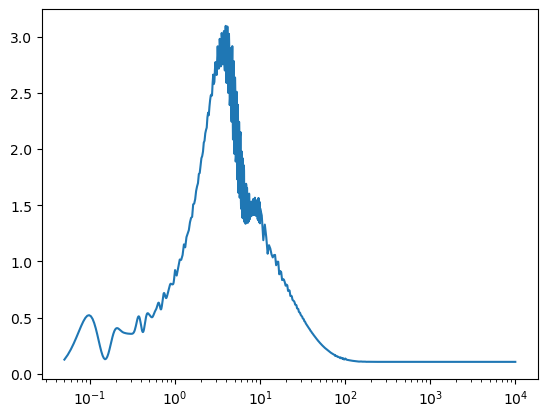

In [119]:
lambda_400 = result[:,0]
plot1d(PSD*1e6,lambda_400)

In [117]:
import matplotlib.pyplot as plt
def plot1d(x,array):
    fig,ax = plt.subplots()
    ax.plot(x,array)
    ax.set_xscale("log")
    plt.show()